In [1]:
import numpy as np
import nmp_util
import sympy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import sparse

In [2]:
data = pd.read_csv('serie4-observationsobs.sec', delimiter = r'\s+', names = ['I', 'z' , 's_z'], skiprows = [0])
display(data)

,I,z,s_z
1,0.05,27.0,3.6
2,0.10,59.0,5.4
3,0.15,146.0,8.5
4,0.17,183.0,7.8
5,0.20,228.0,10.7
6,0.22,228.0,10.7
7,0.25,268.0,9.5
8,0.27,268.5,8.8
9,0.30,277.0,11.8
10,0.32,283.5,11.9


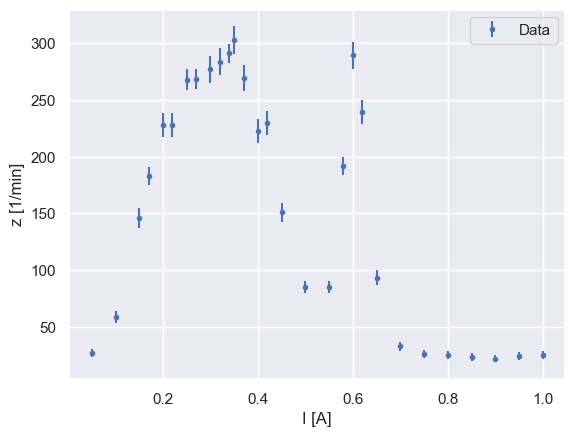

In [3]:
sns.set_theme()
plt.xlabel('I [A]')
plt.ylabel('z [1/min]')
plt.errorbar(data['I'], data['z'], data['s_z'], fmt='.', label = 'Data')
plt.legend()
plt.show()

# Define the functional model with sympy

In [4]:
a_0, a_1, a_2, sigma_1, sigma_2, mu_1, mu_2, I = sympy.symbols('a_0, a_1, a_2, sigma_1, sigma_2, mu_1, mu_2, I')

with sympy.evaluate(False):
    sqrt2pi = sympy.sqrt(2*sympy.pi)
    functional_model_expr = \
        a_1 / (sqrt2pi * sigma_1) * sympy.exp(-(I-mu_1)**2 / (2 * sigma_1**2)) +\
        a_2 / (sqrt2pi * sigma_2) * sympy.exp(-(I-mu_2)**2 / (2 * sigma_2**2)) + a_0

parameter_symbols = [a_0, a_1, a_2, sigma_1, sigma_2, mu_1, mu_2]

display(functional_model_expr)

a_0 + ((a_1/((sigma_1*sqrt(2*pi))))*exp((-(I - mu_1)**2)/((2*sigma_1**2))) + (a_2/((sigma_2*sqrt(2*pi))))*exp((-(I - mu_2)**2)/((2*sigma_2**2))))

In [5]:
weight_matrix = sparse.diags(1/data['s_z'].to_numpy()**2)

functional_model = nmp_util.SympyFunctionalModel(functional_model_expr, parameter_symbols, I)

# the default values are given in the exercise, except for a_0, simply chose far a_0 too, and see if this converges

initial_parameters = np.array([50, 50, 50, 0.05, 0.05, 0.3, 0.6])

functional_model.parameters = initial_parameters.copy()

parameters = []
residuals = []

def log(model : nmp_util.SympyFunctionalModel):
    print(f'Itaration:{model.iterations:2d}, m_0: {model.m_0:.2f}')
    # store these for a later exercise
    parameters.append(model.parameters)
    residuals.append(model.residuals)
    
functional_model.logger = log

functional_model.fit(data['I'], data['z'], weight_matrix)

Itaration: 1, m_0: 5.15
Itaration: 2, m_0: 2.42
Itaration: 3, m_0: 2.00
Itaration: 4, m_0: 1.99
Itaration: 5, m_0: 1.99
Itaration: 6, m_0: 1.99
Itaration: 7, m_0: 1.99
Itaration: 8, m_0: 1.99
Itaration: 9, m_0: 1.99
Itaration:10, m_0: 1.99


In [6]:
print(f'chi statistic for 5%')
print(f'model : {functional_model.chi2_statistic()}')
print(f'critical value : {functional_model.chi2_critical_value(0.05)}')

chi statistic for 5%
model : 86.86410547031329
critical value : 33.92443847144381


parameters:
[2.32548688e+01 7.91245710e+01 1.69971532e+01 1.12614854e-01 2.73968319e-02 3.09340635e-01 6.05751447e-01]
parameter standard errors
[2.62614145e+00 2.73156577e+00 1.09040115e+00 3.79094591e-03 1.78180714e-03 3.79962026e-03 1.90627001e-03]
parameter correlation matrix


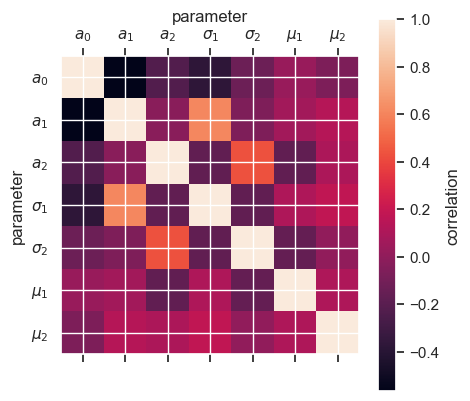

In [7]:
print(f'parameters:')
print(functional_model.parameters)
print(f'parameter standard errors')
stderrs = functional_model.parameter_cov().diagonal()**0.5
print(stderrs)
print(f'parameter correlation matrix')
functional_model.show_correlation()
plt.show()

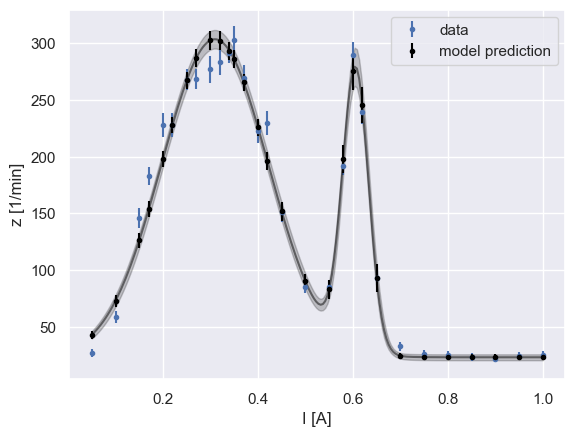

In [8]:
functional_model.plot()
plt.xlabel('I [A]')
plt.ylabel('z [1/min]')
plt.show()

In [9]:
z = functional_model.eval(0.12)
z_err = functional_model.eval_cov_diags(0.12)[0]**0.5
print(f't = {z:.3f} +- {z_err:.3f}')


factor_expr = a_1 / (sqrt2pi * sigma_1)

factor, factor_cov = nmp_util.propagate_error([factor_expr], parameter_symbols, functional_model.parameters, functional_model.parameter_cov())
factor_err = factor_cov[0,0]**0.5
print(f'factor = {factor[0]:.3f} +- {factor_err:.3f}')

t = 91.456 +- 6.037
factor = 280.302 +- 8.402


Delta x:
[-4.10930993e-01  5.69292683e-01 -6.49022982e-03  1.46017546e-03 -2.30887738e-04 -5.69450072e-04 -1.99245484e-04]
residuals :


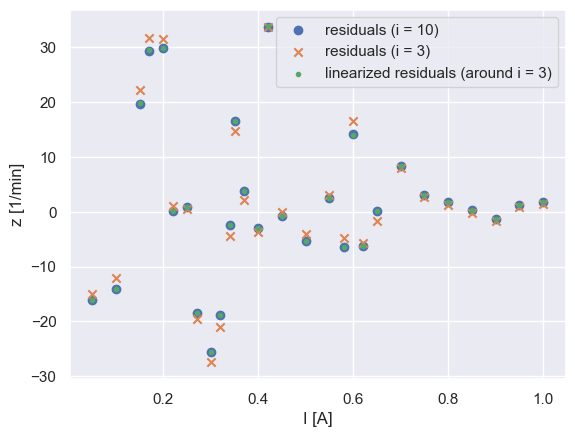

In [13]:
true_residuals = functional_model.residuals

i = 2

delta_params = functional_model.parameters - parameters[i]
print('Delta x:')
print(delta_params)
print('residuals :')

# this checks if the design matrix is a good taylor approximation around the i'th  parameters
linearized_residuals = residuals[i] - functional_model.A @ delta_params

# i+1 because we the first iteration is i = 1, but the arrays are 0-indexed
plt.scatter(functional_model.x, true_residuals, label = f'residuals (i = {len(residuals)})')
plt.scatter(functional_model.x, residuals[i],marker ='x', label = f'residuals (i = {i+1})')
plt.scatter(functional_model.x, linearized_residuals, marker='.', label = f'linearized residuals (around i = {i+1})')
plt.xlabel('I [A]')
plt.ylabel('z [1/min]')
plt.legend()
plt.show()


1.7569689476406771


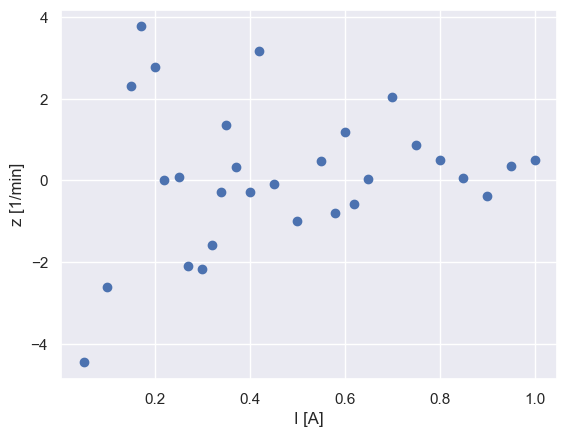

In [11]:
normalized_residuals = functional_model.residuals / data['s_z']
plt.scatter(data['I'], normalized_residuals)
#normalized_residuals = functional_model.residuals / functional_model.eval_cov_diags(data['I'])**0.5
#plt.scatter(data['I'], normalized_residuals)
#normalized_residuals = functional_model.residuals / functional_model.eval_cov_diags(data['I'], 1)**0.5
#plt.scatter(data['I'], normalized_residuals)
plt.xlabel('I [A]')
plt.ylabel('z [1/min]')
print(normalized_residuals.std())